# **SeisMIIC** Tutorial
In the following, we will go through a simple example to compute a ambient noise correlations and monitor velocity changes using **SeisMIIC**.

The main code is hosted here: [SeisMIIC](https://github.com/PeterMakus/PyGLImER).

The documentation, which this notebook is based upon is located here:
[SeisMIIC Documentation](https://petermakus.github.io/PyGLImER/).

Without further ado, we'll dive right into it starting with data download.

## 1. Download the raw data
**SeisMIIC** uses [obspy](https://docs.obspy.org/) to download data from FDSN servers. As an exercise, we will download
data from the station `BP.GHIB` to investigate the coseismic velocity change caused by the 2004 Parkfield earthquake
(see Hadziioannou et. al., 2011).

To download the data, we will use the `miic3.trace_data.waveform.Store_Client` class and its method `download_waveforms_mdl()`.

In [1]:
import os

from obspy.clients.fdsn import Client
from obspy import UTCDateTime

from miic3.trace_data.waveform import Store_Client

# Get notebook path for future reference of the database:
try: ipynb_path
except NameError: ipynb_path = os.getcwd()

os.chdir(ipynb_path)

root = os.path.join(ipynb_path, 'data')
os.makedirs(root, exist_ok=True)

starttime = UTCDateTime(year=2004, month=8, day=15)
endtime = UTCDateTime(year=2004, month=10, day=31)
network = 'BP'
station = 'GHIB'


c = Client('NCEDC')
sc = Store_Client(c, root, read_only=False)
sc.download_waveforms_mdl(
    starttime, endtime, clients=[c], network=network,
    station=station, location='*', channel='BP?')


KeyboardInterrupt: 

Some notes about this:
1. The method `download_waveforms_mdl()` expects a list of clients as input.
2. All arguments accept wildcards

If everything worked fine. This should have created a folder called `data/mseed` and `data/inventory`. Let's check

In [2]:
os.listdir('./data/')

['inventory', 'vel_change', 'figures', 'log', 'mseed', 'corr']

## 2. Compute Correlations
That seems to have worked, so we are ready to use this raw data to compute ambient noise correlations.

### 2.1 Parameters
Parameters are provided as a `yaml` file or a `dict` object. This tutorial comes with an yaml file to process the data. Let's have a short look at it using bash.

In [3]:
!cat params.yaml

#### Project wide parameters
# lowest level project directory
proj_dir : 'data/'
# directory for logging information
log_subdir : 'log'
# levels:
# 'DEBUG', 'INFO', 'WARNING', 'ERROR', or 'CRITICAL'
log_level: 'WARNING'
# folder for figures
fig_subdir : 'figures'
# folder containing preprocessed data


#### parameters that are network specific
net:
    # list of stations used in the project
    # type: list of strings or string, wildcards allowed
    network : 'BP'
    station : 'GHIB'
    # stations : ['D0.BZG', 'D0.ESO', 'D0.KBG', 'D0.KIR']
    # list of channels
    # type: list of strings
    channels : ['BHZ','BHN','BHE']

#### parameters for correlation (emperical Green's function creation)
co:
    # subdirectory of 'proj_dir' to store correlation
    # type: string
    subdir : 'corr'
    # times sequences to read for cliping or muting on stream basis
    # These should be long enough for the reference (e.g. the standard
    # deviation) to be rather independent of the parts to 

Each of the parameters is described in the [Documentation](url.to.doc.org).

To start the computation of the correlation we will use `MPI` and a simple python script, which could look like this:

In [4]:
!cat correlate.py

from time import time

from obspy.clients.fdsn import Client

from miic3.correlate.correlate import Correlator
from miic3.trace_data.waveform import Store_Client

# Path to the paramter file we created in the step before
params = 'params.yaml'
# You don't have to set this (could be None)
client = Client('IRIS')
# root is the same as proj_dir in params.yaml
root = 'data'
sc = Store_Client(client, root)

c = Correlator(sc, options=params)
print('Correlator initiated')
x = time()
st = c.pxcorr()
print('Correlation finished after', time()-x, 'seconds')

## 2.2 Start correlation
To start the correlation, we will use the `mpirun` command in bash:

In [5]:
import os
# This gives number of threads, usually twice as many as physical cores
ncpus = os.cpu_count()/2
!mpirun -n $ncpus python correlate.py

Correlator initiated
Correlator initiated
Correlator initiated
Correlator initiated
Correlator initiated
100%|██████████| 78/78 [02:54<00:00,  2.24s/it]
Correlation finished after 174.60406184196472 seconds
Correlation finished after 174.6861264705658 seconds
Correlation finished after 174.5834879875183 seconds
Correlation finished after 174.70340824127197 seconds
Correlation finished after 174.70343708992004 seconds
Correlation finished after 174.70331454277039 seconds


Now let's have a look at those correlations. To do so, we use the `CorrelationDataBase` object.
All correlations are saved in the folder `data/corr` as defined in our params.yaml file.

In [29]:
from miic3.db.corr_hdf5 import CorrelationDataBase

with CorrelationDataBase('data/corr/BP-BP.GHIB-GHIB.h5', mode='r') as cdb:
    # find the available labels
    print(list(cdb.keys()))

['co', 'stack_86398', 'subdivision']


**SeisMIIC's** standard labels are `'subdivision` for the correlations of corr_len and `stack_*stacklen*` for the stack (with *stacklen* being the length of the stack in seconds).

**SeisMIIC** uses some sort of "combined seed codes" structured as above.

In [30]:
with CorrelationDataBase('data/corr/BP-BP.GHIB-GHIB.h5', mode='r') as cdb:
    # find the available labels
    print(cdb.get_available_channels(
        tag='stack_86398', network='BP-BP', station='GHIB-GHIB'))
    cst = cdb.get_data('BP-BP', 'GHIB-GHIB', 'BP1-BP2', 'stack_86398')
print(type(cst))

['BP1-BP2', 'BP1-BP3', 'BP2-BP3']
<class 'miic3.correlate.stream.CorrStream'>


`cst` is now a `CorrStream` - an obspy based object to handle correlations. We can plot those in a section plot for example by time:

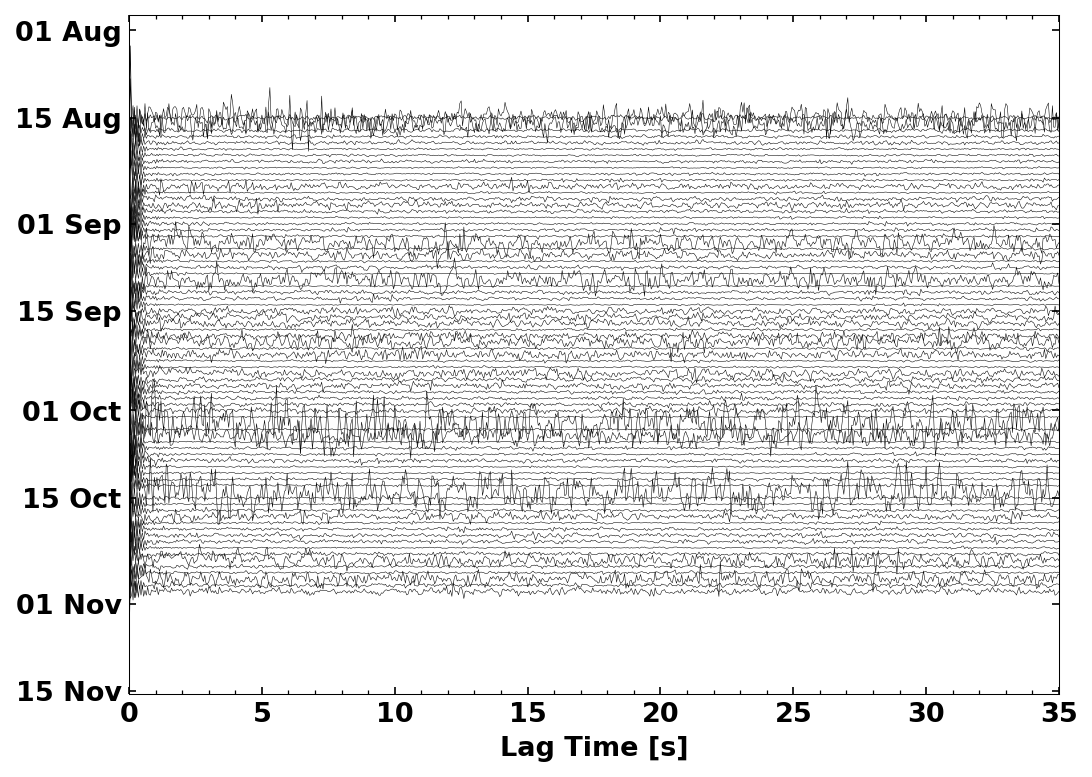

In [8]:
cst.plot(scalingfactor=1e6, timelimits=[0, 35])

We can also look at a single correlation:

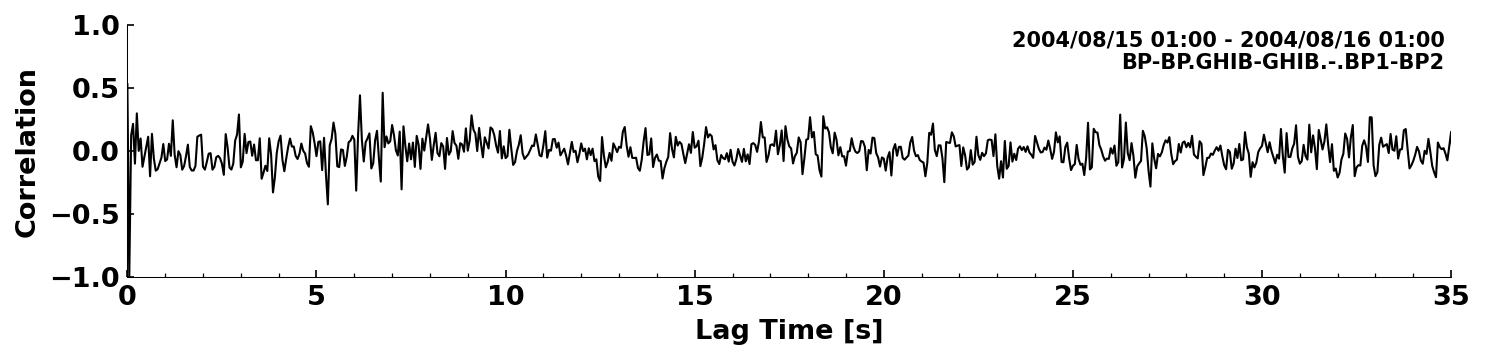

In [32]:
cst[1].plot(tlim=[0,35])

## 3. Monitoring
Similarly to the Correlation we can start the monitor via a simple script:

In [10]:
!cat monitor.py

from miic3.monitor.monitor import Monitor

yaml_f = 'params.yaml'
m = Monitor(yaml_f)
m.compute_velocity_change_bulk()


In [24]:
try: ipynb_path
except NameError: ipynb_path = os.getcwd()

os.chdir(ipynb_path)
!mpirun -n $ncpus python monitor.py

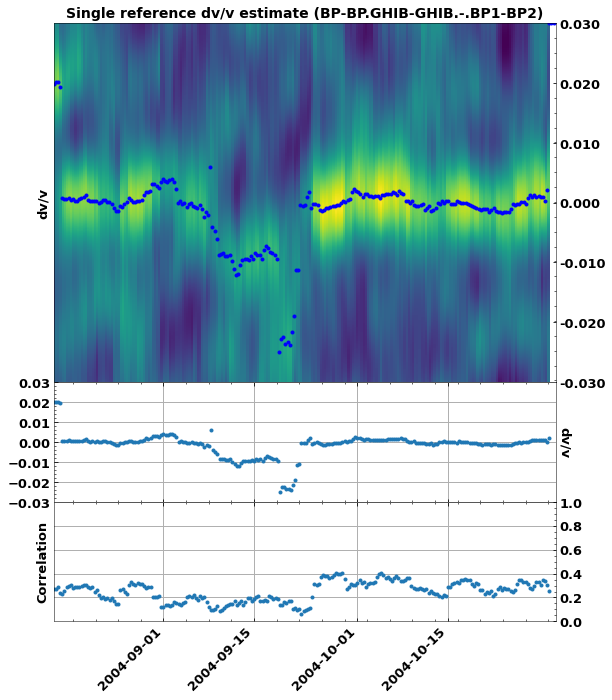

In [26]:
from miic3.monitor.dv import read_dv
dv = read_dv('data/vel_change/DV-BP-BP.GHIB-GHIB.BP1-BP2.npz')
dv.plot()

Even with comparably little data, we can see the velocity drop. Note that we had to
take fairly long time windows (especially given the quite long periods).